## Music Classification ##

Music classification is an age-old conundrum, fueling many a debate between friends. Are the Eagles a Rock band? Folk? Country? One person’s rock, may be another person’s pop, and genres may vary wildly depending on who you talk to. The fact of the matter is: musical genres are not, in fact, genomic classes like those in biology, which link objects by defined physical characteristics. Musical genres sprung up organically, and often retroactively, as people tried to group songs of a particular style into one category. These classifications are largely subjective, blurring the lines between musical genres as we understand them. 

 _“Rock and roll (often written as rock & roll, rock 'n' roll or rock 'n roll) is a genre of popular music that originated and evolved in the United States during the late 1940s and early 1950s from musical styles such as gospel, jump blues, jazz, boogie woogie, and rhythm and blues, and country music.”_

As you can see, this definition is derivative, describing “Rock and Roll” by the genres from which it was born and not by technical qualities which distinguish it from other types of music. Machine learning provides a potential solution to the music classification problem. Using convolutional neural networks (CRNNs), we can attempt to learn which features define songs of particular genres and determine an objective, feature-based definition for each.


### Goals ###

- Train a CRNN to classify songs into 4 categories: jazz, rock, classical, and hip hop
- Determine the most relevant features for classifying the mel-spectograms
- Develop a technical definition for each genre, using features from the mode


In [2]:
import numpy as np
from numpy.fft import fftshift, fftn
import spotipy
import urllib.request
import spotipy.util as util
from scipy.io import wavfile as wav
import scipy.signal as signal
import librosa
from pydub import AudioSegment
import os
import matplotlib.pyplot as plt


## Spotify Web API##

If you have a Spotify account, the Spotify Web API contains a wealth of songs, as well as features for each of those songs. More information can be found here. To query the api, it is necessary to generate a client_id in order to prompt for a user token.

Using the package `spotipy`, you can easily access the api and parse the data it provides. The data for this project have already been provided in the ####E#SDFSDFS.zip file, but we will still go through how it was scraped and prepared.



In [3]:
username = 'wm396401'
scope = 'playlist-modify-public'
c_id = '683d9a998d244af697540959b03e461d'
c_s = '8e64414e6aaa408092d055b8da3dbb4b'
r_uri = 'https://en.wikipedia.org/wiki/Ella_Fitzgerald'

token = util.prompt_for_user_token(username,scope,client_id = c_id, client_secret = c_s,redirect_uri=r_uri)
spotify = spotipy.Spotify(token)

#length of song clip (ms)


### Scraping Data ###

Spotipy allows you to extract 30 second previews of songs from the playlist of your choosing. For this project, three playlists were chosen for each genre from Spotify's pre-generated playlists. The playlist chosen were:


#### Jazz ####
- Late Night Jazz
- Coffee Table Jazz
- Big Band

#### Classical ####
- Classical Essentials
- Morning Classical
- Orchestra 100: Spotify Picks

#### Hip Hop ####
- Rap Caviar
- Feelin' Myself
- Hip-Hop Classics: Def Jam

#### Rock ####
- Rock Classics
- 90s Rock Anthems
- 80s Rock Anthems

These playlists are by no means exhaustive, but they should give a good range of music for each genre. For each track, a 30 second preview was downloaded and clipped to be only 3 seconds long (the time it takes for a human to classify a song).



In [4]:
num_ms = 3000
jazz_playlist = ['spotify:playlist:37i9dQZF1DX4wta20PHgwo','spotify:playlist:37i9dQZF1DWVqfgj8NZEp1',
                 'spotify:playlist:37i9dQZF1DX6G7arXBXa3A']
classical_playlist = ['spotify:playlist:37i9dQZF1DWWEJlAGA9gs0','spotify:playlist:37i9dQZF1DX9OZisIoJQhG',
                     'spotify:playlist:37i9dQZF1DXddGd6mP5X2a']
hip_hop_playlist = ['spotify:playlist:37i9dQZF1DX0XUsuxWHRQd','spotify:playlist:37i9dQZF1DX6GwdWRQMQpq',
                   'spotify:playlist:37i9dQZF1DX7Mq3mO5SSDc']
rock_playlist = ['spotify:playlist:37i9dQZF1DWXRqgorJj26U','spotify:playlist:37i9dQZF1DX1rVvRgjX59F',
                 'spotify:playlist:37i9dQZF1DX1spT6G94GFC']


def extract_songs(genre,playlists):
    print(genre)
    length = 0
    ids = []
    for playlist in playlists:
        results = spotify.user_playlist_tracks('wm396401',playlist)
    
        for track in results['items']:
            url = track['track']['preview_url']
            if url:
                ids.append(track['track']['id'])
                urllib.request.urlretrieve(url, 'Audio_Files/%s/track_%s.mp3'%(genre,length))
                song = AudioSegment.from_mp3( 'Audio_Files/%s/track_%s.mp3'%(genre,length))

                extract = song[0:num_ms]
                extract.export( 'Audio_Files/%s/track_%s_cropped.wav'%(genre,length), format="wav")
                os.remove('Audio_Files/%s/track_%s.mp3'%(genre,length))
                length+=1
    print(length)
    return length,ids

length_jazz,jazz_ids = extract_songs('Jazz',jazz_playlist)
length_classical,classical_ids = extract_songs('Classical',classical_playlist)
length_hip_hop,hiphop_ids = extract_songs('hip_hop',hip_hop_playlist)
length_rock,rock_ids = extract_songs('Rock',rock_playlist)




Jazz
146
Classical
196
hip_hop
139
Rock
198


## Visualization

Before we try to train a neural network using the audio files from the playlists, let's  take a look at the features provided by Spotify. The goal of this section is to visualize these features and identify if there are any naturally occuring clusters for different genres.
Previously, we requested the metadata of each playlist and extracted the id of each track. Using these ids, we parse the music features from Spotify API. The features include `danceability`, `energy`, `key`, `loudness`, `mode`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence` and `tempo`.

In [5]:
def feature_extract(ids):
    fea = []
    num_track_up = 0
    num_track_down = 0
    for i in range(int(len(ids)/50)+1):
        num_track_up += 50
        num_track_down = num_track_up - 50
        if num_track_up < len(ids):
            fea.append(spotify.audio_features(ids[num_track_down:num_track_up]))
        else:
            fea.append(spotify.audio_features(ids[num_track_down:len(ids)]))
    flatten_fea = [item for sublist in fea for item in sublist]
    danceability = [track["danceability"] for track in flatten_fea]
    energy = [track["energy"] for track in flatten_fea]
    key = [track["key"] for track in flatten_fea]
    loudness = [track["loudness"] for track in flatten_fea]
    mode = [track["mode"] for track in flatten_fea]
    speechiness = [track["speechiness"] for track in flatten_fea]
    acousticness = [track["acousticness"] for track in flatten_fea]
    instrumentalness = [track["instrumentalness"] for track in flatten_fea]
    liveness = [track["liveness"] for track in flatten_fea]
    valence = [track["valence"] for track in flatten_fea]
    tempo = [track["tempo"] for track in flatten_fea]
    return danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo

In [6]:
j_danceability,j_energy,j_key,j_loudness,j_mode,j_speechiness,j_acousticness,j_instrumentalness,j_liveness,j_valence,j_tempo = feature_extract(jazz_ids)
c_danceability,c_energy,c_key,c_loudness,c_mode,c_speechiness,c_acousticness,c_instrumentalness,c_liveness,c_valence,c_tempo = feature_extract(classical_ids)
h_danceability,h_energy,h_key,h_loudness,h_mode,h_speechiness,h_acousticness,h_instrumentalness,h_liveness,h_valence,h_tempo= feature_extract(hiphop_ids)
r_danceability,r_energy,r_key,r_loudness,r_mode,r_speechiness,r_acousticness,r_instrumentalness,r_liveness,r_valence,r_tempo = feature_extract(rock_ids)

### Visualization of features using histogram

We use histogram to visualize all eleven features in four different genres. Each row represents one feature and each column represents one genre as suggested by the subplot title. To look at the data qualitatively, we can find that the distributions of all features in hip-hop and rock are very similar which implies that these two music genres are more difficult to distinguish. However, the distribution of features in the classical music is significantly different to the other three genres which makes it more distinguishable from others, e.g., the energy distribution of the classical music concentrates at the lower end.

In [7]:
def feature_hist(*argv):
    features = ["jazz: danceability","classcical: danceability","hiphop: danceability","rock: danceability",
            "jazz: energy","classcical: energy","hiphop: energy","rock: energy",
            "jazz: key","classcical: key","hiphop: key","rock: key",
            "jazz: loudness","classcical: loudness","hiphop: loudness","rock: loudness",
            "jazz: mode","classcical: mode","hiphop: mode","rock: mode",
            "jazz: speechiness","classcical: speechiness","hiphop: speechiness","rock: speechiness",
            "jazz: acousticness","classcical: acousticness","hiphop: acousticness","rock: acousticness",
            "jazz: instrumentalness","classcical: instrumentalness","hiphop: instrumentalness","rock: instrumentalness",
            "jazz: liveness","classcical: liveness","hiphop: liveness","rock: liveness",
            "jazz: valence","classcical: valence","hiphop: valence","rock: valence",
            "jazz: tempo","classcical: tempo","hiphop: tempo","rock: tempo"]
    fig, axs = plt.subplots(11, 4,figsize=(20, 30), sharey=True, tight_layout=True)
    n_bins = 9
    for i in range(len(argv)):
        row = int(i/4)
        column = i%4
        axs[row,column].hist(argv[i],bins=n_bins)
    for j in range(len(axs.flat)):
        axs.flat[j].set(xlabel='Feature Values', ylabel='Probability (%)')
        axs.flat[j].set_title("Histogram of %s"%features[j])
    plt.show()

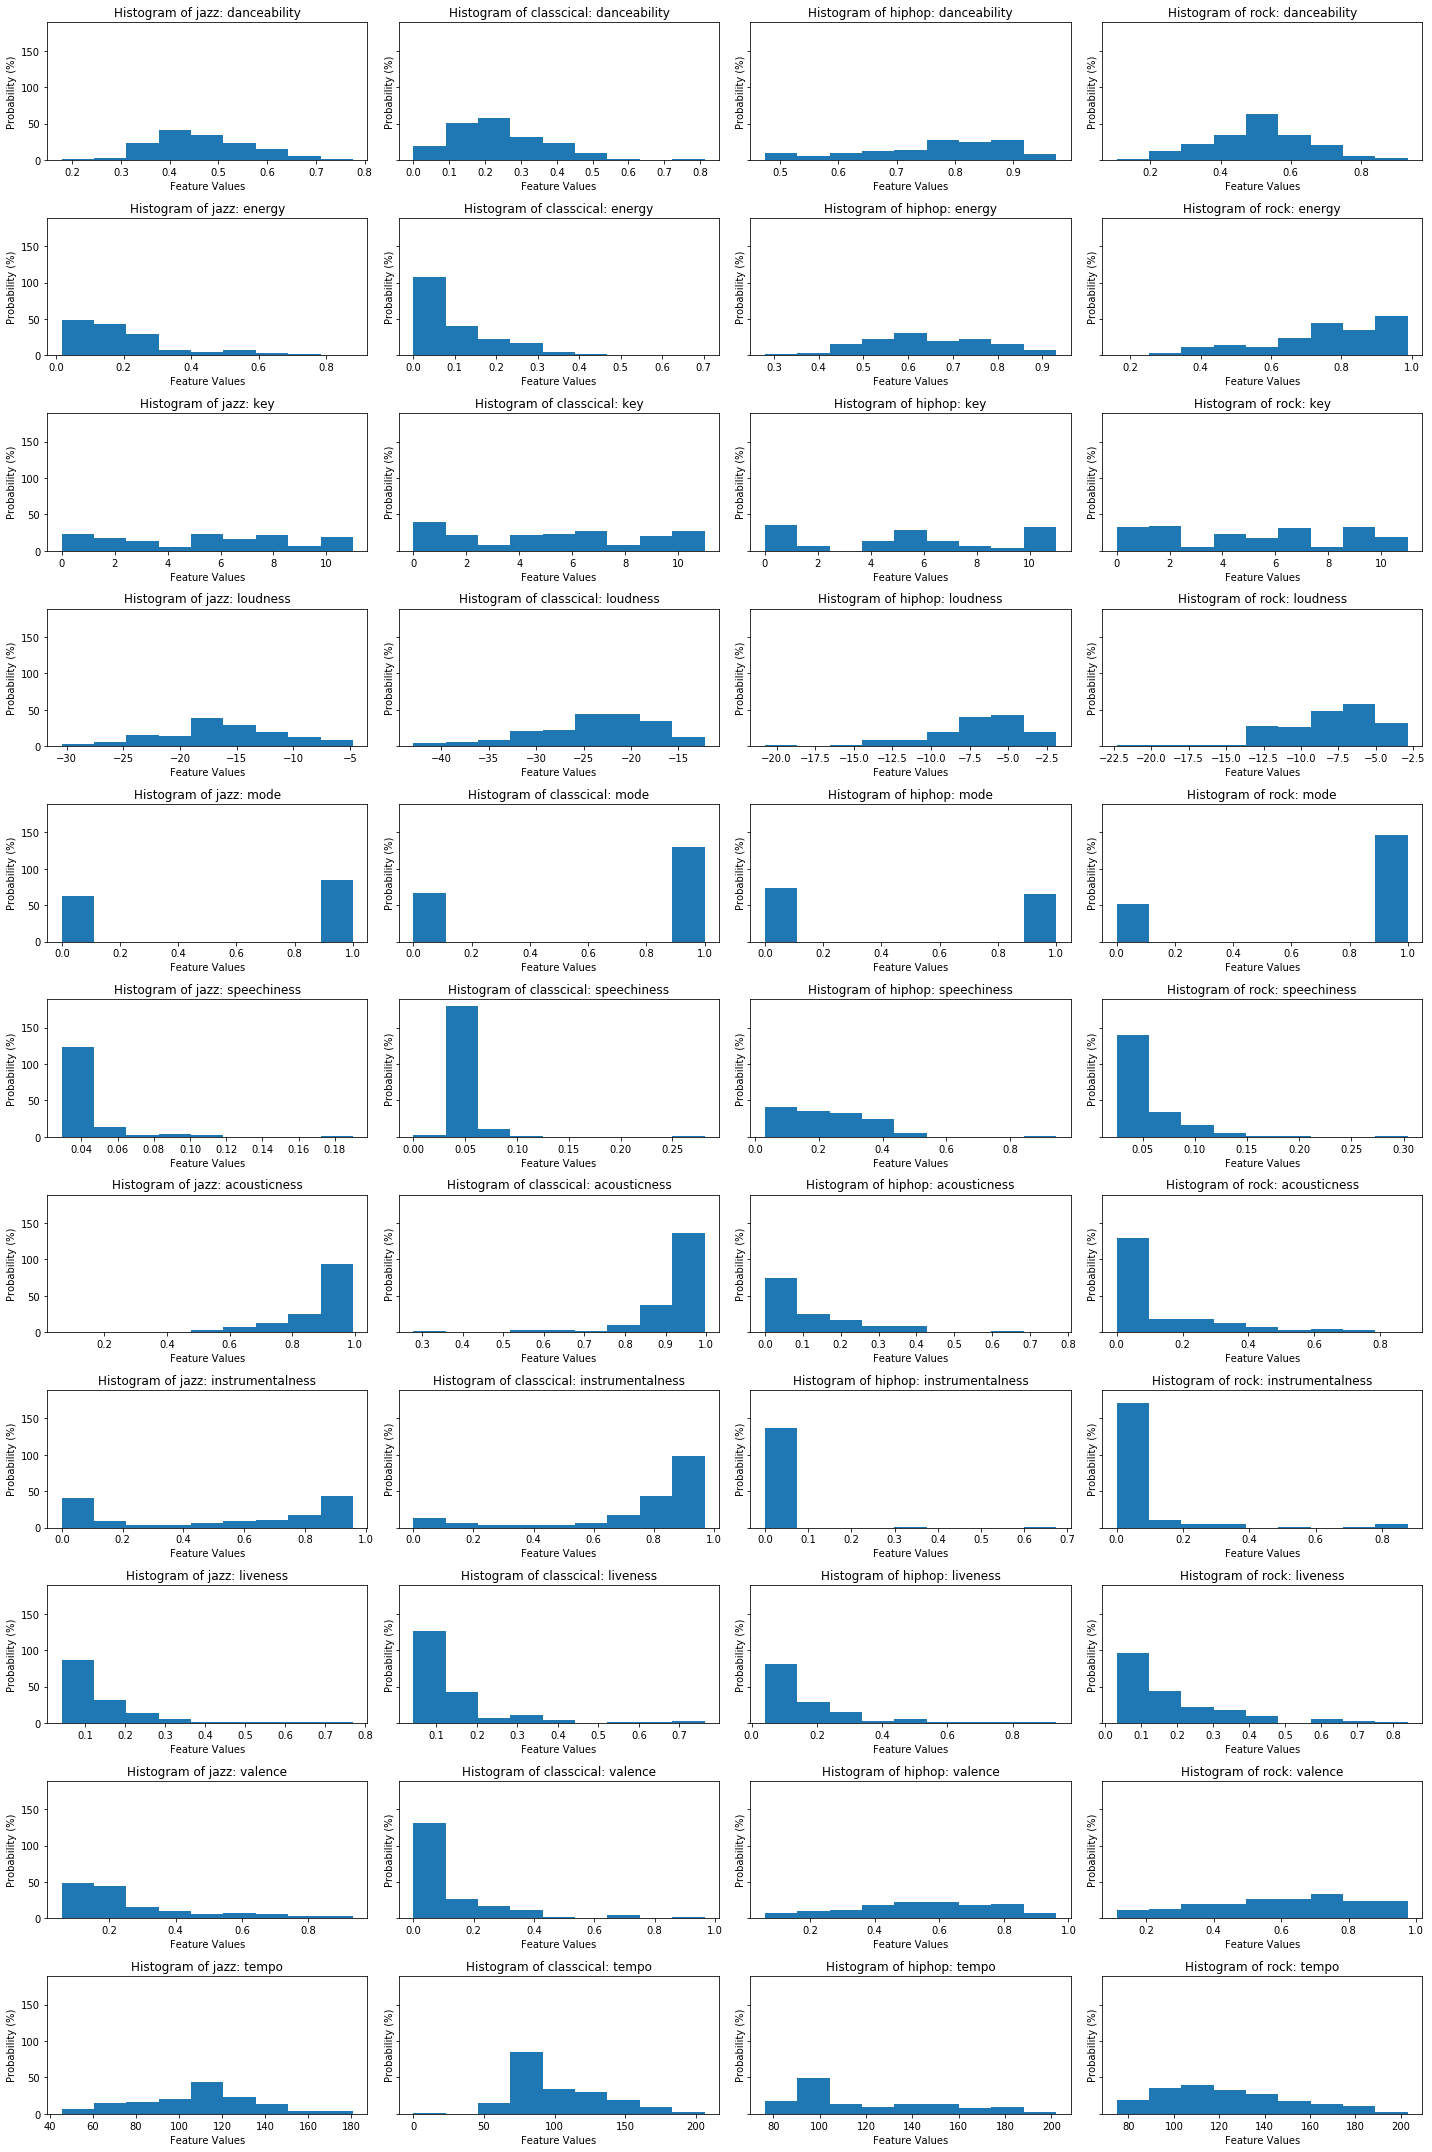

In [8]:
feature_hist(j_danceability,c_danceability,h_danceability,r_danceability,
            j_energy,c_energy,h_energy,r_energy,
            j_key,c_key,h_key,r_key,
            j_loudness,c_loudness,h_loudness,r_loudness,
            j_mode,c_mode,h_mode,r_mode,
            j_speechiness,c_speechiness,h_speechiness,r_speechiness,
            j_acousticness,c_acousticness,h_acousticness,r_acousticness,
            j_instrumentalness,c_instrumentalness,h_instrumentalness,r_instrumentalness,
            j_liveness,c_liveness,h_liveness,r_liveness,
            j_valence,c_valence,h_valence,r_valence,
            j_tempo,c_tempo,h_tempo,r_tempo)

In [9]:
def extract_example(ids):
    examples = []
    num_track_up = 0
    num_track_down = 0
    for i in range(int(len(ids)/50)+1):
        num_track_up += 50
        num_track_down = num_track_up - 50
        if num_track_up < len(ids):
            features = spotify.audio_features(ids[num_track_down:num_track_up])
            for j in features:
                example = []
                example.append(j['danceability'])
                example.append(j['energy'])
                example.append(j['key'])
                example.append(j['loudness'])
                example.append(j['mode'])
                example.append(j['speechiness'])
                example.append(j['acousticness'])
                example.append(j['instrumentalness'])
                example.append(j['liveness'])
                example.append(j['valence'])
                example.append(j['tempo'])
                examples.append(example)
        else:
            features = spotify.audio_features(ids[num_track_down:len(ids)])
            for j in features:
                example = []
                example.append(j['danceability'])
                example.append(j['energy'])
                example.append(j['key'])
                example.append(j['loudness'])
                example.append(j['mode'])
                example.append(j['speechiness'])
                example.append(j['acousticness'])
                example.append(j['instrumentalness'])
                example.append(j['liveness'])
                example.append(j['valence'])
                example.append(j['tempo'])
                examples.append(example)
    return examples

In [10]:
jazz_ex = extract_example(jazz_ids)
class_ex = extract_example(classical_ids)
hip_ex = extract_example(hiphop_ids)
rock_ex = extract_example(rock_ids)

### Principle component analysis

In this section, we join the samples of every pair the genre to perform principle component analysis (PCA). The idea is to check the percentage of the variance can be explained by each feature. For example, in the classical and jazz, classical and rock, and classical and hip-hop datasets, the first the principle component can explain 30%, 50% and 42% of the variance. 
As a result, if we visualize the data in a 2D plot with both of the principle components, we can easily find natural clusters in these cases.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
def PCA_plot_variance(*argv):
    fig, axs = plt.subplots(len(argv), len(argv),figsize=(20, 10), sharey=True, tight_layout=True)
    titles = ["classical","jazz","rock","hip-hop"]
    PCA_components = []
    for i in range(len(argv)):
        for j in range(len(argv)):
            arg = []
            arg = argv[i] + argv[j]
            df = pd.DataFrame(arg) 
            input_std = StandardScaler().fit_transform(df)
            pca = PCA(n_components=len(arg[0]))
            pCs = pca.fit_transform(input_std)
            # Plot the explained variances
            features = range(pca.n_components_)
            axs[i,j].bar(features, pca.explained_variance_ratio_, color='black')
            plt.xticks(features)
            # Save components to a DataFrame
            PCA_components.append(pCs)
    for k in range(len(axs.flat)):
        row = int(k/4)
        column = k%4
        axs.flat[k].set_title("%s vs. %s"%(titles[row],titles[column]))
        axs.flat[k].set(xlabel='PCA features', ylabel='variance %')
        axs.flat[k].set_xticks(features) 
    return PCA_components

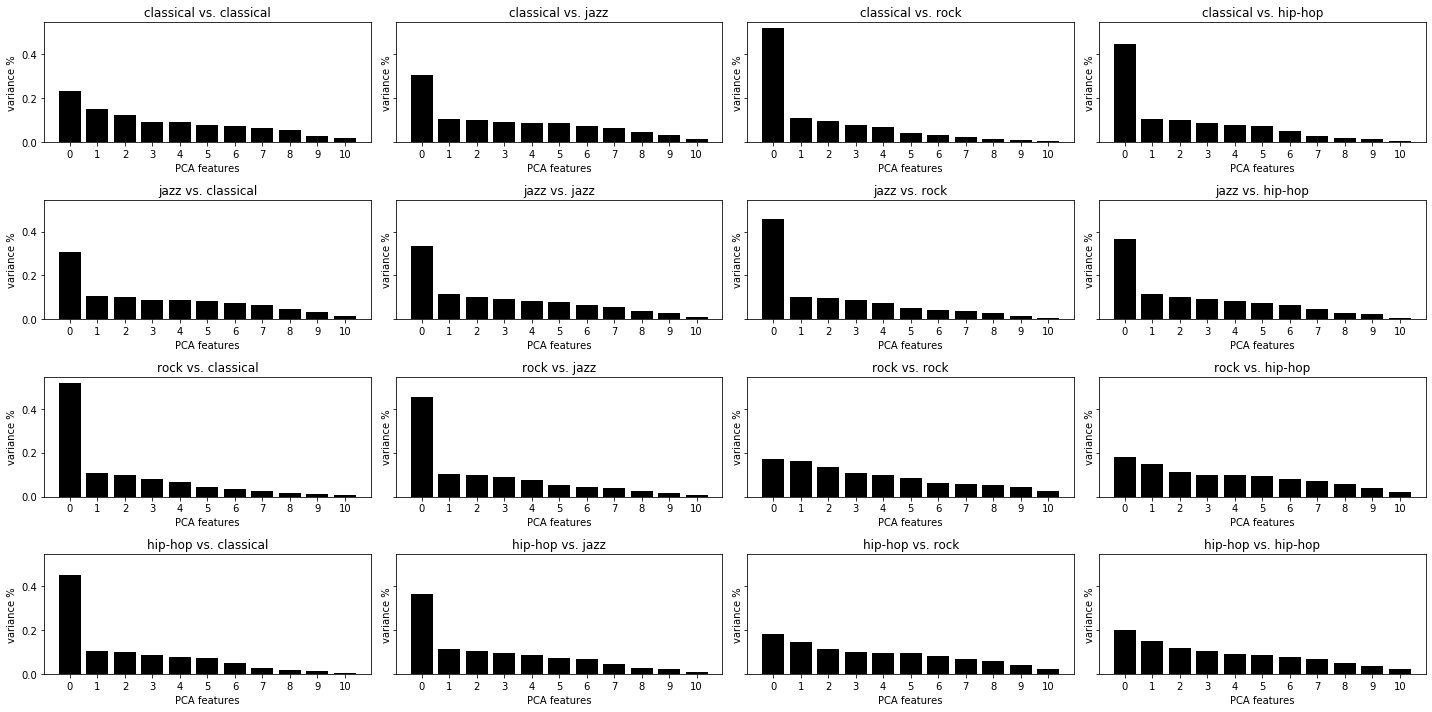

In [13]:
list_pca_comps = PCA_plot_variance(class_ex,jazz_ex,hip_ex,rock_ex)

In [14]:
def PCA_plot(list_pca_components):
    titles = ["classical","jazz","rock","hip-hop"]
    fig, axs = plt.subplots(4, 4,figsize=(10, 10), sharey=True, tight_layout=True)
    for i in range(len(list_pca_components)):
        pca_comp = pd.DataFrame(list_pca_components[i])
        row = int(i/4)
        column = i%4
        axs[row,column].scatter(pca_comp[0], pca_comp[1], alpha=.1, color='black')
    for k in range(len(axs.flat)):
        row = int(k/4)
        column = k%4
        axs.flat[k].set_title("%s vs. %s"%(titles[row],titles[column]))
        axs.flat[k].set(xlabel='PCA 1', ylabel='PCA 2')

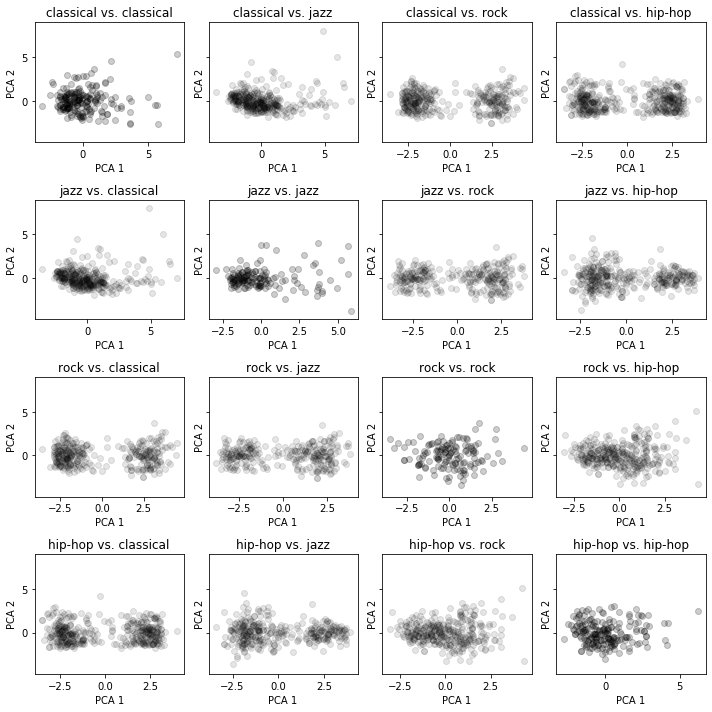

In [15]:
PCA_plot(list_pca_comps)

### K-mean clustering

In this section, we try to use k-mean clustering method to see if there are any natural clusters exist in the combined dataset of all four genres. The first step is to optimize the number of clusters should be used in the clustering exercise. The optimization is performed by calculating the inertia for each cluster number selection and checking how much inertia is reduced by adding additional cluster.

In [16]:
def Kmean_cluster_optimization(*argv):
    arg = []
    for i in range(len(argv)):
        arg += argv[i]
    df = pd.DataFrame(arg) 
    input_std = StandardScaler().fit_transform(df)
    print (len(arg[0]))
    pca = PCA(n_components=len(arg[0]))
    pcs = pca.fit_transform(input_std)
    PCA_components = pd.DataFrame(pcs)
    # Optimization for the number of clusters in the Kmean clustering
    num_cluster = range(1, 10)
    inertias = []
    for k in num_cluster:
        model = KMeans(n_clusters=k) # Create a KMeans instance with k clusters: model
        model.fit(PCA_components.iloc[:,:3])# Fit model to samples
        inertias.append(model.inertia_) # Append the inertia to the list of inertias

    plt.plot(num_cluster, inertias, '-o', color='black')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(num_cluster)
    plt.annotate('n = 2', xy=(2, 2200), xytext=(3, 3000),
            arrowprops=dict(facecolor='red', shrink=0.05))
    plt.annotate('n = 4 (known genres)', xy=(4, 1400), xytext=(5, 2000),
        arrowprops=dict(facecolor='red', shrink=0.05))
    plt.show()
    return PCA_components

11


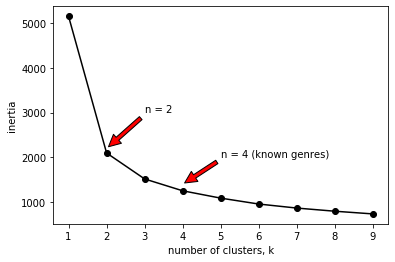

In [17]:
pca_cps = Kmean_cluster_optimization(class_ex,rock_ex,hip_ex,rock_ex)

In [18]:
def Kmean_cluster(PCA_components,num_clusters):
    km = KMeans(n_clusters=num_clusters).fit(PCA_components)
    centroids = km.cluster_centers_
    labels=np.array([km.labels_])
    plt.scatter(PCA_components[0], PCA_components[1], c = km.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:,0], centroids[:,1], c='red', s=50)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

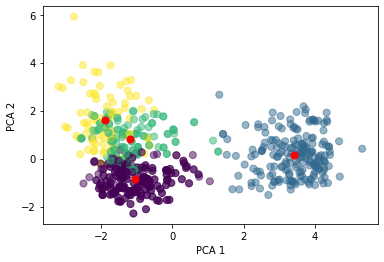

In [19]:
Kmean_cluster(pca_cps,4) 

Though K-mean clustering gives us a rough classification of songs into genres, our model should be much more robust as it makes use of all the information available from the original audio data.

## Mel Spectrogram ##

These 3-second clips were then converted to Mel-spectrograms, which served as inputs to our model. A Mel-spectrogram is a graphical representation of all the frequencies present during a given clip of music, over a certain amount of time. A clip of music is binned into small () time lengths and the fourier transform taken of each bin. The fourier transform decomposes a signal into its constituent frequencies. The audio signal itself is difficult to analyze, but by transforming it into fourier space, we are able to determine features of interest. The result is a plot of frequency distribution vs time. An example Mel-spectogram can be seen below. The intensity of the plot corresponds to the amplitude of the signal at that given frequency.

A Mel-spectogram was created for each track from each playlist and stored in an array X. The tracks were labeled according to the genre from which they came.



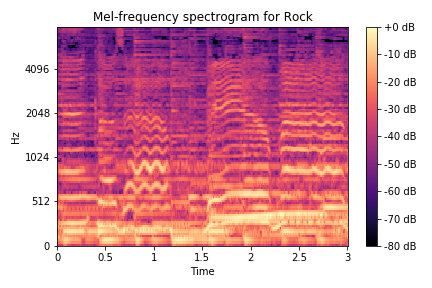

In [36]:
from IPython.display import Image
Image("Rock-spec.png")

In [21]:
import librosa.display
rate,data = wav.read('Audio_Files/hip_hop/track_8_cropped.wav')   
#convert from stereo to mono
sample = (data[:,0]+data[:,1])/2

S = librosa.feature.melspectrogram(y=sample, sr=rate, n_fft=2048, hop_length=512,fmax=8000)
lengths = [length_jazz,length_classical,length_hip_hop,length_rock]
genres = ['Jazz','Classical','hip_hop','Rock']
total = length_jazz+length_classical+length_hip_hop+length_rock
X = np.zeros((S.shape[0],S.shape[1],total))
labels = np.zeros((total,1))
n = 0

for j in range(len(lengths)):
    label = j
    length = lengths[j]
    genre = genres[j]
    for i in range(length):
        rate,data = wav.read('Audio_Files/%s/track_%s_cropped.wav'%(genre,i))
        #convert from stereo to mono
        sample = (data[:,0]+data[:,1])/2
        S = librosa.feature.melspectrogram(y=sample, sr=rate, n_fft=2048, hop_length=512,fmax=8000)
        #convert power to dB
        labels[n,0] = label
        X[:,:,n] = librosa.power_to_db(S, ref=np.max)
        n+=1

X = np.transpose(X, (2,1,0)) #Make sure don't run this line multiple times
    

# Splitting Train, Validation, Test Data

We use the train_test_split function from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into three: training, validation, and testing.

Our model uses the training data to train on; this data is seen and used to fit the model parameters. The validation data is used to fine-tune the hyperparameters. The test data is used to evaluate the performance of our model and has never been seen by the model.

In [22]:
from sklearn.model_selection import train_test_split
X_train_all, X_test, y_train_all, y_test_raw = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train_raw, y_val_raw = train_test_split(X_train_all, y_train_all, test_size=0.1)
y_test = np.zeros([np.shape(y_test_raw)[0],4])
for i in range(np.shape(y_test_raw)[0]):
    y_test[i,int(y_test_raw[i][0])] = 1
y_train = np.zeros([np.shape(y_train_raw)[0],4])
for i in range(np.shape(y_train_raw)[0]):
    y_train[i,int(y_train_raw[i][0])] = 1
y_val = np.zeros([np.shape(y_val_raw)[0],4])
for i in range(np.shape(y_val_raw)[0]):
    y_val[i,int(y_val_raw[i][0])] = 1
    
#print (np.shape(X)[0],np.shape(X_train_all)[0],np.shape(X_test)[0],np.shape(X_train)[0],np.shape(X_val)[0],np.shape(y_test))

## Build and Train our CRNN Model

We use keras (an open-source neural network library) to build our Convolutional Recurrent Neural Network Model (CRNN), using a Sequential Architecture which is simply a linear stack of layers.

The main architecture that we use is:
    1. 2 Convolution layers consisting of 1D Convolution filters
    2. LSTM
    3. Dense Layer
We use an Adam optimizer and a categorical cross entropy function for training.
    
![Architecture](Architecture.png)

Long Short Term Memory networks (LSTMs) are a special kind of RNNs, capable of learning short-term and long-term structures of songs. While RNNs essentially are a chain of repeating modules of neural networks, the structure of an LSTM is slightly more complicated than that. More information about the LSTM can be found [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/), but basically, LSTM contain "analog gates" that can contain information outside the normal flow of the neural network that help with understanding the long term structure of the song.

In [23]:
import keras
from keras import models
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras import backend
from keras.preprocessing import image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [24]:
batch_size = 32
num_genres = 4
n_features = X_train.shape[2]
n_time = X_train.shape[1]
n_layers = 2
len_filter = 5
num_filters = 28
lstm_units = 48
num_epochs = 60
num_hidden = 32
L2_regularization = 0.01


def build_model(num_genres):
    print('Building model...')
    model = Sequential()
    regularizer = regularizers.l2(L2_regularization)
    for i in range(n_layers):
        model.add(Conv1D(filters=num_filters, kernel_size=len_filter,
                kernel_regularizer=regularizer))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.4))

    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(0.4))
    
    model.add(Dense(num_hidden, kernel_regularizer=regularizer))
    model.add(Dropout(0.4))
    
    model.add(Dense(num_genres,activation='softmax'))
    print('Compiling model...')
    opt = Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
                  metrics=['accuracy'])
    return model

In [25]:
def train_model(x_train, y_train, x_val, y_val):
    
    model = build_model(num_genres)
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
                        validation_data=(x_val, y_val), verbose=1)
   
    #print(model.summary())
    return model, history

In [26]:
def show_summary_stats(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [27]:
import warnings
warnings.filterwarnings('ignore')

model, history  = train_model(X_train, y_train, X_val, y_val)

Building model...

Compiling model...

Training...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 488 samples, validate on 55 samples
Epoch 1/60





488/488 [==============================] - 19s 38ms/step - loss: 2.5756 - acc: 0.2807 - val_loss: 2.4512 - val_acc: 0.3091
Epoch 2/60
488/488 [==============================] - 8s 17ms/step - loss: 2.4775 - acc: 0.3627 - val_loss: 2.3595 - val_acc: 0.4545
Epoch 3/60
488/488 [==============================] - 8s 17ms/step - loss: 2.3988 - acc: 0.3791 - val_loss: 2.2940 - val_acc: 0.5273
Epoch 4/60
488/488 [==============================] - 8s 17ms/step - loss: 2.3343 - acc: 0.4549 - val_loss: 2.2370 - val_acc: 0.5636
Epoch 5/60
488/488 [==============================] - 8s 17ms/step - loss: 2.2999 - acc: 0.4652 - val_loss: 2.1936 - val_acc: 0.6364
Epoch 6/60
488/4

488/488 [==============================] - 8s 17ms/step - loss: 1.5829 - acc: 0.7766 - val_loss: 1.6541 - val_acc: 0.7455
Epoch 36/60
488/488 [==============================] - 8s 17ms/step - loss: 1.5384 - acc: 0.7746 - val_loss: 1.7439 - val_acc: 0.5455
Epoch 37/60
488/488 [==============================] - 8s 17ms/step - loss: 1.5163 - acc: 0.8033 - val_loss: 1.6251 - val_acc: 0.7273
Epoch 38/60
488/488 [==============================] - 8s 17ms/step - loss: 1.5535 - acc: 0.7766 - val_loss: 1.5593 - val_acc: 0.7636
Epoch 39/60
488/488 [==============================] - 8s 17ms/step - loss: 1.4873 - acc: 0.7910 - val_loss: 1.6233 - val_acc: 0.7091
Epoch 40/60
488/488 [==============================] - 8s 17ms/step - loss: 1.5658 - acc: 0.7520 - val_loss: 1.6092 - val_acc: 0.6909
Epoch 41/60
488/488 [==============================] - 8s 17ms/step - loss: 1.5453 - acc: 0.7725 - val_loss: 1.6253 - val_acc: 0.7273
Epoch 42/60
488/488 [==============================] - 8s 17ms/step - loss

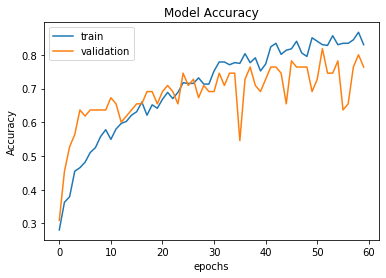

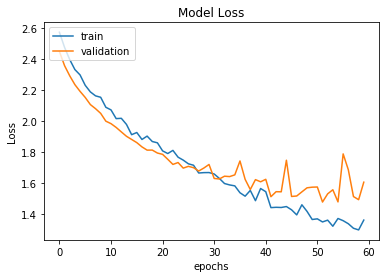

In [28]:
show_summary_stats(history)
#model.summary()

Training accuracy = 0.8524590163934426
136/136 [==============================] - 1s 6ms/step
Test accuracy = 0.7205882352941176


Text(33.0, 0.5, 'predicted test label')

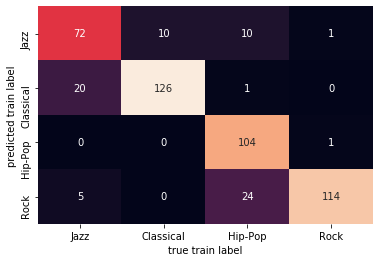

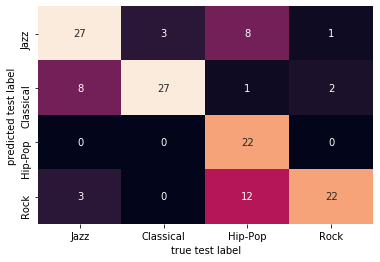

In [29]:
dict_genres = {'Jazz':0, 'Classical':1, 'Hip-Pop':2, 'Rock':3}

y_true = np.argmax(y_train, axis = 1)
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3]
print('Training accuracy =',accuracy_score(y_true, y_pred))
plt.figure(1)
mat = confusion_matrix(y_true, y_pred,labels)
ax = sns.heatmap(mat, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
bottom, top = ax.get_ylim()
ax.set_ylim(4.0, 0)
plt.xlabel('true train label')
plt.ylabel('predicted train label')

model.evaluate(X_test, y_test)
test_true = np.argmax(y_test, axis = 1)
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
print('Test accuracy =', accuracy_score(test_true, test_pred))
plt.figure(2)
mat = confusion_matrix(test_true, test_pred, labels)
ax = sns.heatmap(mat, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
bottom, top = ax.get_ylim()
ax.set_ylim(4.0, 0)
plt.xlabel('true test label')
plt.ylabel('predicted test label')

## Analyzing Audio Features

We want to be able to see what our model is learning from the Mel-Spectrograms of the audio files. To do this, we look at the activation outputs from the CRNN Model, after each Convolution layer for all the four categories.

For example, in the Jazz genre, we look at the Mel-Spectrogram of one song as well as the 2nd, 7th (corressponding to the first and second Convolution layer outputs), and last layer activations.

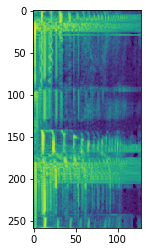

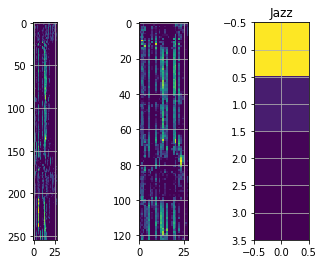

In [30]:
layer_outputs = [layer.output for layer in model.layers[:15]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

mel_jazz = np.expand_dims(X[1],axis=0)
# power_jazz = librosa.core.db_to_power(np.transpose(X[1]))
# audio_jazz = librosa.feature.inverse.mel_to_audio(power_jazz)
# wav_jazz = sf.write('jazz.wav',audio_jazz,rate)
plt.imshow(mel_jazz[0])
activations_jazz = activation_model.predict(mel_jazz)
activations_jazz[-1] = np.expand_dims(activations_jazz[-1],axis=2)
fig, axs = plt.subplots(1, 3)
for ax, i in zip(axs,[2,7,-1]):
    ax.imshow(activations_jazz[i][0])
    ax.grid(True)
plt.title('Jazz')
plt.show() #2,7,last layer activations

Now, we take 100 songs from each genre and look at the sum of the 2nd Convolution Layer output for all songs. 

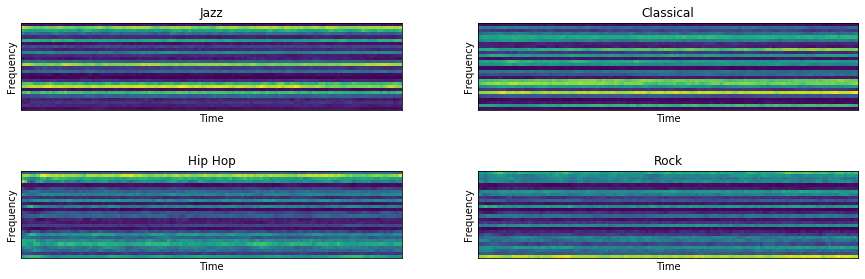

In [31]:
n = 100

add_j,add_c,add_h,add_r = np.ones((123,28)),np.ones((123,28)),np.ones((123,28)),np.ones((123,28))

for j in range(n):
    mel_jazz = np.expand_dims(X[j],axis=0)  
    activations_jazz = activation_model.predict(mel_jazz)
    add_j += activations_jazz[7][0]

    mel_class = np.expand_dims(X[212+j],axis=0)  
    activations_class = activation_model.predict(mel_class)
    add_c += activations_class[7][0]
    
    mel_hip = np.expand_dims(X[441+j],axis=0)  
    activations_hip = activation_model.predict(mel_hip)
    add_h += activations_hip[7][0]
    
    mel_rock = np.expand_dims(X[572+j],axis=0)  
    activations_rock = activation_model.predict(mel_rock)
    add_r += activations_rock[7][0]
    


fig, axs = plt.subplots(nrows=2,ncols=2,figsize= (15,5))

axs[0,0].imshow(add_j.T)
axs[0,0].set_title('Jazz')
axs[0,1].imshow(add_c.T)
axs[0,1].set_title('Classical')
axs[1,0].imshow(add_h.T)
axs[1,0].set_title('Hip Hop')
axs[1,1].imshow(add_r.T)
axs[1,1].set_title('Rock')
for i in range(2):
    for j in range(2):
    
        axs[i,j].set(xlabel='Time',ylabel='Frequency')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.show()

### Defining Genres ###

Learning features from a CRNN is a common problem which we had difficulty solving. To help visualize what the model looks for in the Mel Spectogram, all of the outputs after the 2nd convolution layer for each track were added for each genre. These plots can be seen below. There is not a lot we can learn from these plots in order to develop a definition for each genre, but it is cool to see what the model thinks is relevant. The y axis in these plots is the frequency and the x axis is time. Though pooling has occured, we can see that there are certain frequencies which the model associates with each genre.

Determining a definition from our model may be difficult, so we need to enlist the help of spotipy once more. Spotify has assembled a list of features for each 

